In [2]:
# !pip install shap
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost
# !pip install 

In [3]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime 
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series 
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import VAR
import pmdarima as pm #auto arima
import sklearn.metrics as metrics

import shap #explainable AI - XAI
from sklearn.ensemble import RandomForestRegressor

### Getting the weekly food demand data for center product combination

In [4]:
demand_df = pd.read_csv('train.csv')
fulfilment_df = pd.read_csv('fulfilment_center_info.csv') #center mapping
meal_info_df = pd.read_csv('meal_info.csv') #meal mapping

In [5]:
product_cuisine_dict = dict(zip(meal_info_df.category, meal_info_df.cuisine))
product_dict=dict([(index,key) for index,key in enumerate(product_cuisine_dict)])
print(product_dict)

{0: 'Beverages', 1: 'Extras', 2: 'Soup', 3: 'Other Snacks', 4: 'Salad', 5: 'Rice Bowl', 6: 'Starters', 7: 'Sandwich', 8: 'Pasta', 9: 'Desert', 10: 'Biryani', 11: 'Pizza', 12: 'Fish', 13: 'Seafood'}


In [6]:
product_id_dict = dict(zip(meal_info_df.meal_id, meal_info_df.category))
# product_cuisine_dict
meal_id_dict=dict([(index,key) for index,key in enumerate(product_id_dict)])
print(meal_id_dict)

{0: 1885, 1: 1993, 2: 2539, 3: 1248, 4: 2631, 5: 1311, 6: 1062, 7: 1778, 8: 1803, 9: 1198, 10: 2707, 11: 1847, 12: 1438, 13: 2494, 14: 2760, 15: 2490, 16: 1109, 17: 2290, 18: 1525, 19: 2704, 20: 1878, 21: 2640, 22: 2577, 23: 1754, 24: 1971, 25: 2306, 26: 2139, 27: 2826, 28: 2664, 29: 2569, 30: 1230, 31: 1207, 32: 2322, 33: 2492, 34: 1216, 35: 1727, 36: 1902, 37: 1247, 38: 2304, 39: 1543, 40: 1770, 41: 2126, 42: 1558, 43: 2581, 44: 1962, 45: 1571, 46: 2956, 47: 2104, 48: 2444, 49: 2867, 50: 1445}


In [7]:
center_region_df = dict(zip(fulfilment_df.center_id, fulfilment_df.region_code))
# center_region_df
center_df=dict([(index,key) for index,key in enumerate(center_region_df)])
print(center_df)

{0: 11, 1: 13, 2: 124, 3: 66, 4: 94, 5: 64, 6: 129, 7: 139, 8: 88, 9: 143, 10: 101, 11: 86, 12: 32, 13: 149, 14: 152, 15: 92, 16: 27, 17: 14, 18: 26, 19: 104, 20: 77, 21: 23, 22: 97, 23: 146, 24: 113, 25: 145, 26: 80, 27: 55, 28: 186, 29: 99, 30: 91, 31: 20, 32: 106, 33: 81, 34: 73, 35: 29, 36: 43, 37: 102, 38: 61, 39: 50, 40: 83, 41: 57, 42: 126, 43: 177, 44: 67, 45: 174, 46: 59, 47: 58, 48: 65, 49: 39, 50: 132, 51: 89, 52: 162, 53: 75, 54: 72, 55: 41, 56: 10, 57: 110, 58: 52, 59: 93, 60: 74, 61: 34, 62: 137, 63: 153, 64: 24, 65: 109, 66: 108, 67: 36, 68: 157, 69: 17, 70: 161, 71: 42, 72: 53, 73: 30, 74: 76, 75: 68, 76: 51}


In [8]:
#demand data
demand_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


In [9]:
demand_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [10]:
demand_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders'],
      dtype='object')

#### filtering train data based on center id and mean id and imputing missing data

In [11]:
def get_data(demand_df,center,meal_id):
    condition=(demand_df['center_id']==center)&(demand_df['meal_id']==meal_id)
    demand_df_1=demand_df.loc[condition,:]
    demand_df_1 = demand_df_1.groupby(pd.Grouper(key="week")).sum()
    print(demand_df_1.index.is_unique) #check for unique records based on index
    demand_df_2=demand_df_1[['checkout_price', 'base_price','emailer_for_promotion', 'homepage_featured', 'num_orders']]
    return demand_df_2
demand_df_2 =  get_data(demand_df,55,1993)
demand_df_2

True


,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,,
1,136.83,135.83,0,0,270
2,133.89,133.89,0,0,121
3,134.86,133.86,0,0,258
4,134.89,133.89,0,0,82
5,147.50,145.50,0,0,81
...,...,...,...,...,...
141,149.41,148.41,0,0,134
142,152.35,152.35,0,0,189
143,151.35,150.35,0,0,109


In [12]:
#imputing missing values if they exist
demand_df_2 = demand_df_2.reindex(range(1, 146), fill_value= np.NaN)
if demand_df_2.isnull().values.any():
    print("hello")
    demand_df_2["num_orders"]=demand_df_2["num_orders"].fillna(demand_df_2['num_orders'].median())
    demand_df_2["checkout_price"]=demand_df_2["checkout_price"].fillna(demand_df_2['checkout_price'].median())
    demand_df_2["base_price"]=demand_df_2["base_price"].fillna(demand_df_2['base_price'].median())
    demand_df_2["emailer_for_promotion"]=demand_df_2["emailer_for_promotion"].fillna(demand_df_2['emailer_for_promotion'].median())
    demand_df_2["homepage_featured"]=demand_df_2["homepage_featured"].fillna(demand_df_2['homepage_featured'].median())

In [13]:
#getting test data for unseen forecasting
def get_test_data(test_df,center,meal_id):
    condition=(test_df['center_id']==center)&(test_df['meal_id']==meal_id)
    test_df=test_df.loc[condition,:]
    test_df = test_df.groupby(pd.Grouper(key="week")).sum()
    print(test_df.index.is_unique)
    demand_test_df=test_df[['checkout_price', 'base_price','emailer_for_promotion', 'homepage_featured']]
    return demand_test_df

demand_test_df = pd.read_csv('food_Demand_test.csv')

demand_test_df = get_test_data(demand_test_df,55,1993)
demand_test_df

True


,checkout_price,base_price,emailer_for_promotion,homepage_featured
week,,,,
146,160.11,159.11,0,0
147,156.20,156.20,0,0
148,158.14,159.14,0,0
149,158.11,159.11,0,0
150,158.11,160.11,0,0
151,158.14,159.14,0,0
152,158.17,156.17,0,0
153,159.11,160.11,0,0
154,157.14,158.14,0,0


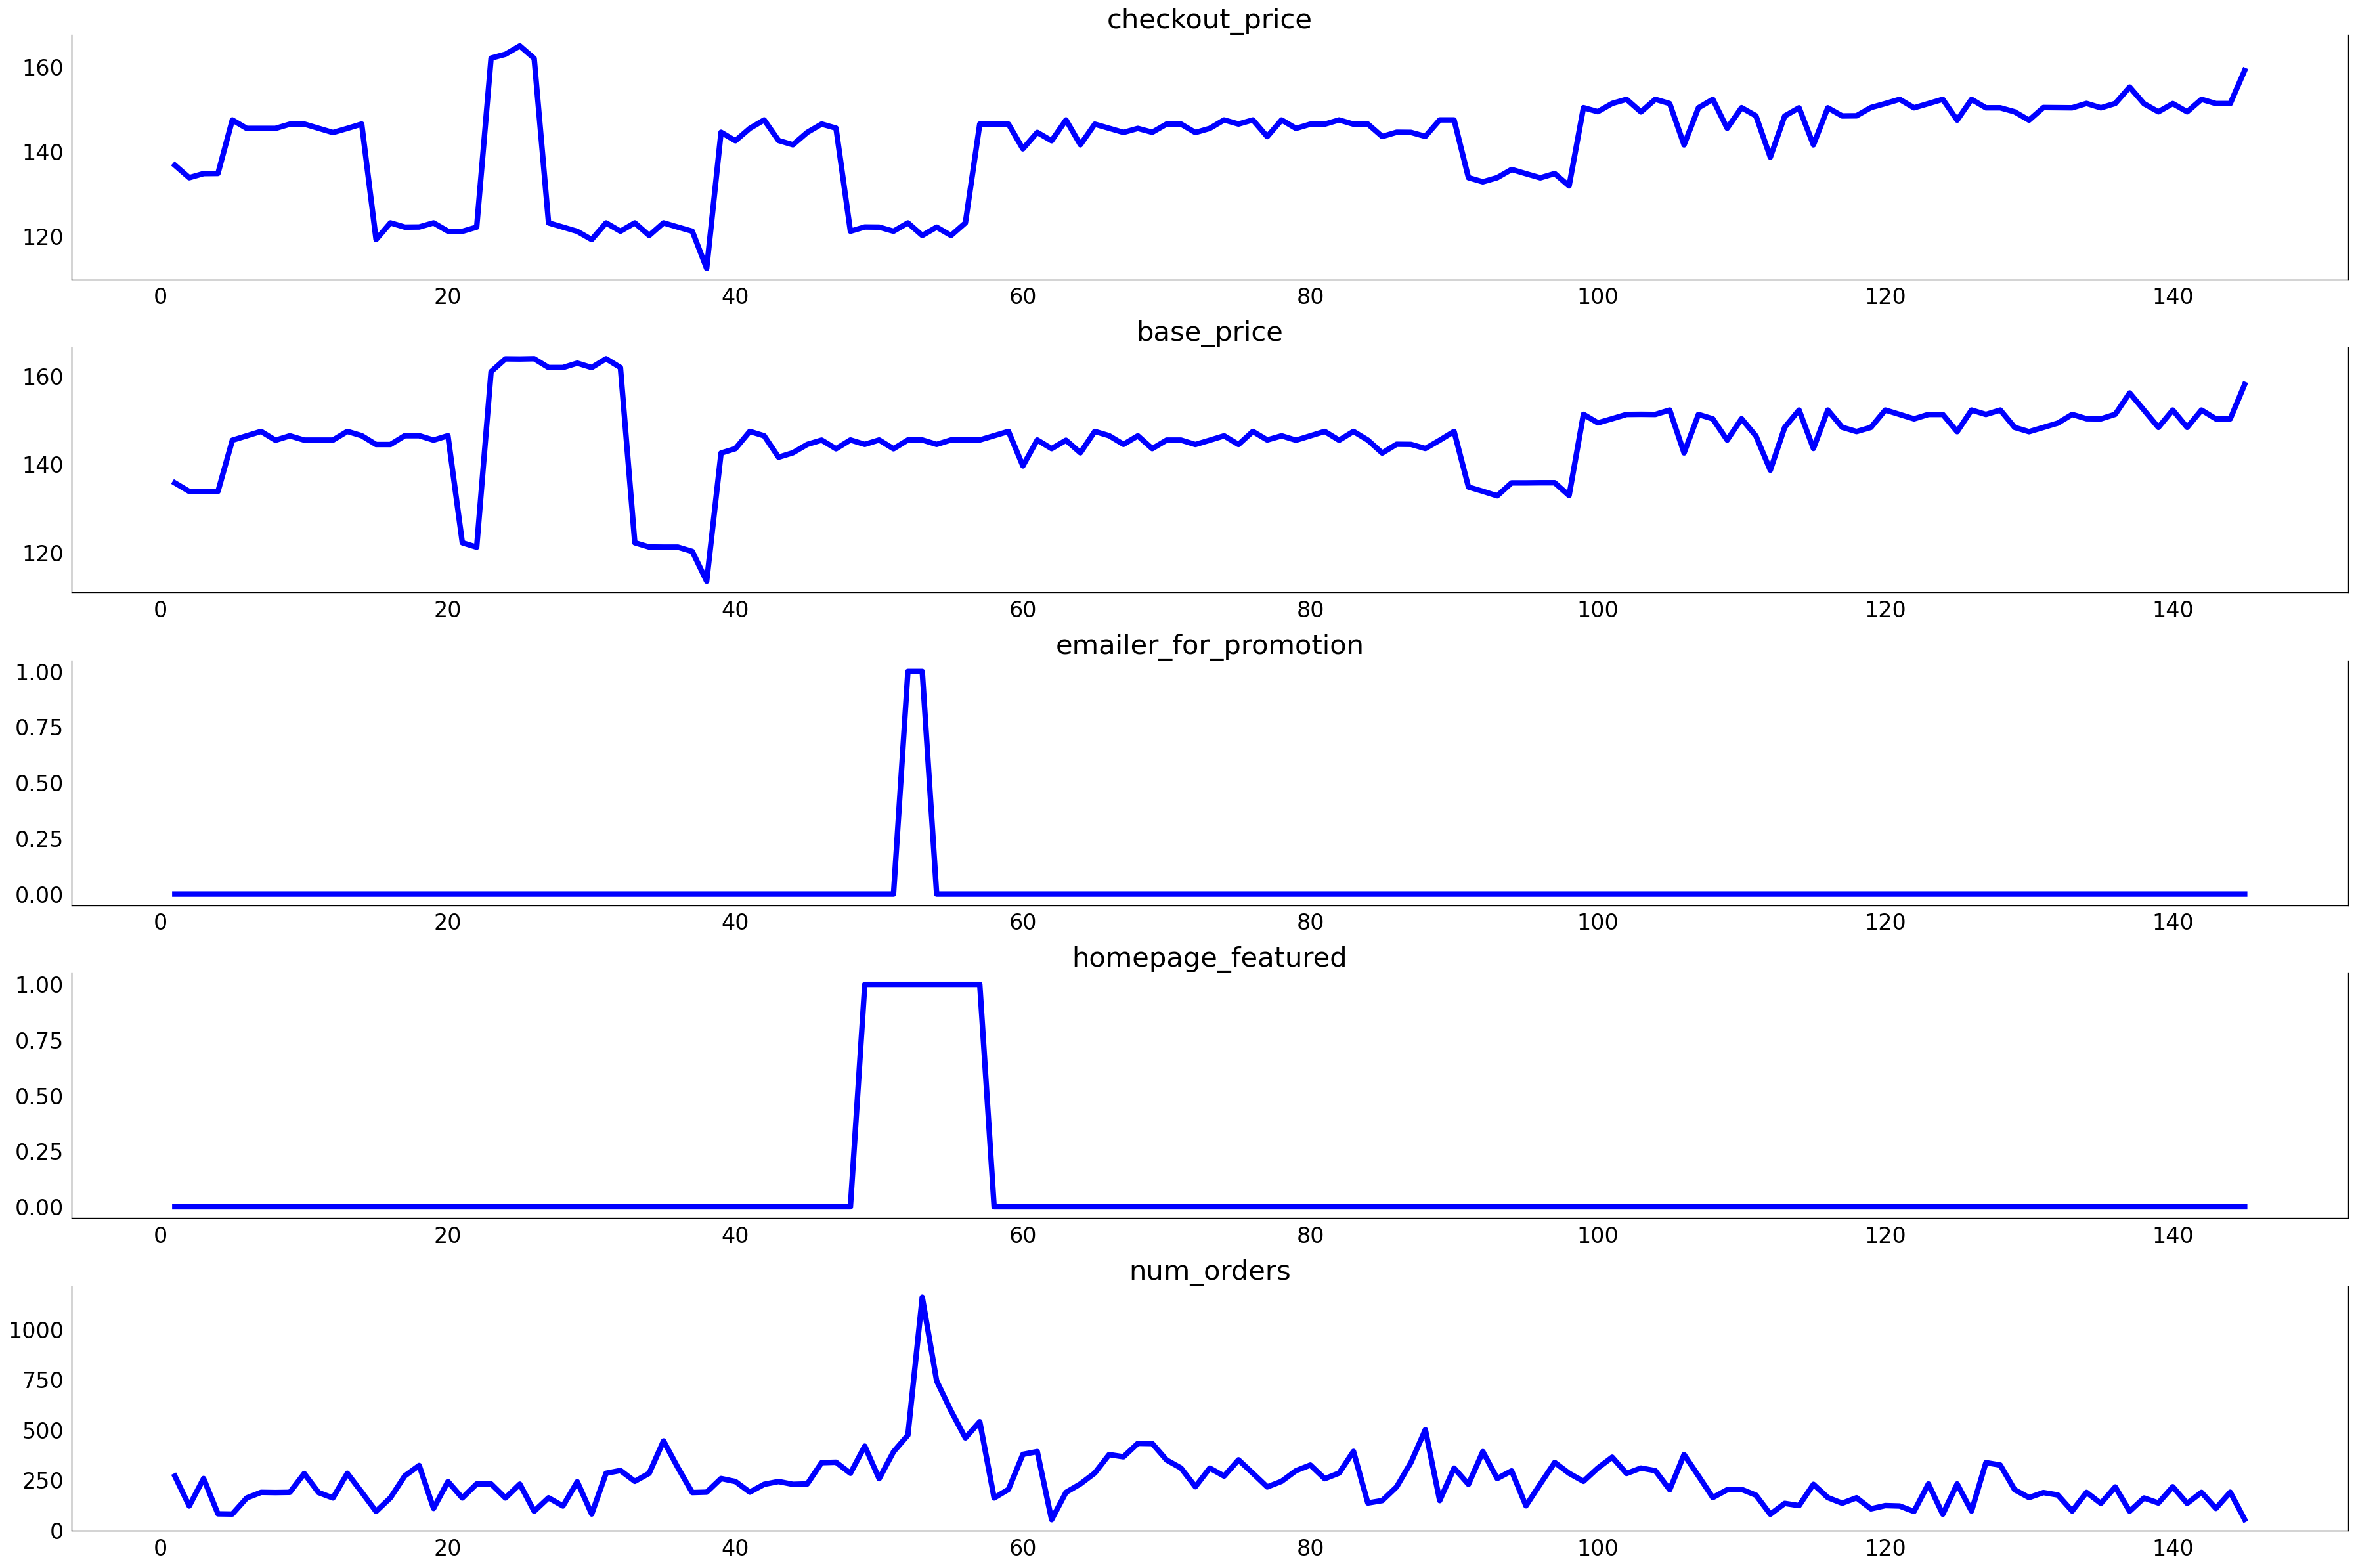

In [14]:
# Plot
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(30,20))
for i, ax in enumerate(axes.flatten()):
    data = demand_df_2[demand_df_2.columns[i]]
    ax.plot(data, color='blue', linewidth=5)
    # Decorations
    ax.set_title(demand_df_2.columns[i], fontsize=25)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=20)

plt.tight_layout();

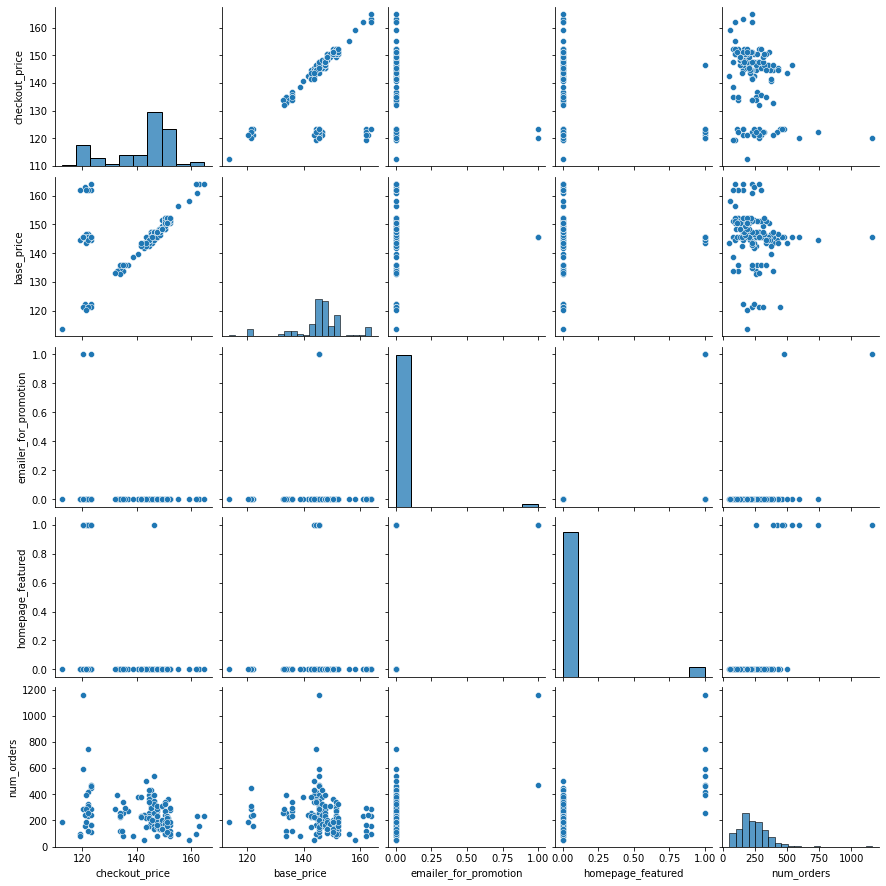

In [15]:
sns.pairplot(demand_df_2)

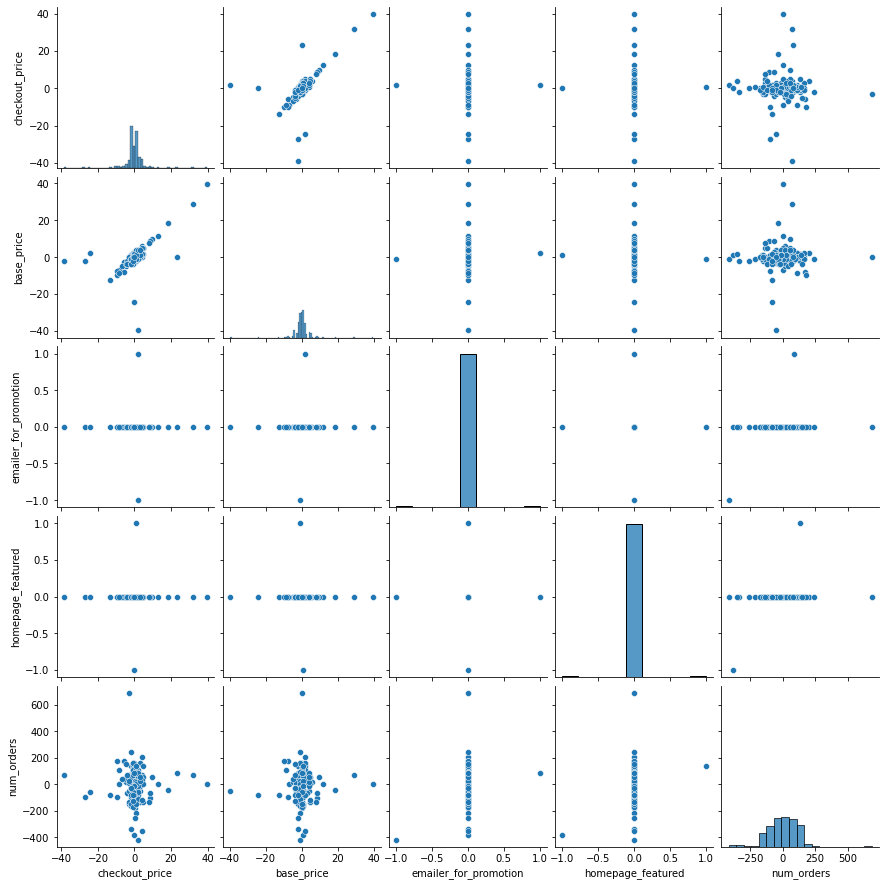

In [16]:
#spurious regression
sns.pairplot(demand_df_2.diff())

In [17]:
corr = demand_df_2.corr()
corr.style.background_gradient(cmap='coolwarm')

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
checkout_price,1.000000,0.485448,-0.206098,-0.384036,-0.303514
base_price,0.485448,1.000000,-0.003228,-0.020091,-0.148892
emailer_for_promotion,-0.206098,-0.003228,1.000000,0.459722,0.499989
homepage_featured,-0.384036,-0.020091,0.459722,1.000000,0.597145
num_orders,-0.303514,-0.148892,0.499989,0.597145,1.000000


In [18]:
corr2 = demand_df_2.diff().corr()
corr2.style.background_gradient(cmap='coolwarm')

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
checkout_price,1.000000,0.591658,-0.000000,0.007916,-0.008995
base_price,0.591658,1.000000,0.026405,-0.017339,0.021273
emailer_for_promotion,-0.000000,0.026405,1.000000,0.000000,0.232113
homepage_featured,0.007916,-0.017339,0.000000,1.000000,0.239076
num_orders,-0.008995,0.021273,0.232113,0.239076,1.000000


### Correlation and scatter plot fails to explain the relationship between the variables hence we will check multicollinearlty using VIF (variable inflation factor)

In [19]:
#to check multicollinearity we just need the independant variables
test = demand_df_2.drop(['num_orders'], axis = 1)
test

,checkout_price,base_price,emailer_for_promotion,homepage_featured
week,,,,
1,136.83,135.83,0,0
2,133.89,133.89,0,0
3,134.86,133.86,0,0
4,134.89,133.89,0,0
5,147.50,145.50,0,0
...,...,...,...,...
141,149.41,148.41,0,0
142,152.35,152.35,0,0
143,151.35,150.35,0,0


In [20]:
# VIF dataframe to detect multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i)
                          for i in range(len(test.columns))]
  
print(vif_data)

                 feature         VIF
0         checkout_price  221.500085
1             base_price  224.704640
2  emailer_for_promotion    1.288431
3      homepage_featured    1.533419


##### Since the VIF of  checkout_price  and  base_price  224.704640 is very high, it shows high multicolllinearity between the independent variables, hence will drop checkout_price and check for VIF again.


In [21]:
#the VIF number should be max 10, remove the one with high VIF and check again
test = demand_df_2.drop(['num_orders', 'checkout_price'], axis = 1)


# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = test.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(test.values, i)
                          for i in range(len(test.columns))]
  
print(vif_data)

                 feature       VIF
0             base_price  1.065267
1  emailer_for_promotion  1.285715
2      homepage_featured  1.350867


#### Checking if our data is stationary using ADF Test and converting it into stationary using differencing especially for predicting using VAR(vector autoregression) models

In [22]:
#test stationarity
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [23]:
# Call the adfuller_test() on each series.
# ADF Test on each column
for name, column in demand_df_2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "checkout_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0709
 No. Lags Chosen       = 13
 Critical value 1%     = -3.481
 Critical value 5%     = -2.884
 Critical value 10%    = -2.579
 => P-Value = 0.7265. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "base_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9074
 No. Lags Chosen       = 0
 Critical value 1%     = -3.477
 Critical value 5%     = -2.882
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "emailer_for_promotion" 
    -----------------------------------------------
 Null Hypothesis: Data ha

In [24]:
diff_df = demand_df_2.diff().dropna()
diff_df

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,,
2,-2.94,-1.94,0.0,0.0,-149.0
3,0.97,-0.03,0.0,0.0,137.0
4,0.03,0.03,0.0,0.0,-176.0
5,12.61,11.61,0.0,0.0,-1.0
6,-2.00,1.00,0.0,0.0,80.0
...,...,...,...,...,...
141,-1.94,-3.94,0.0,0.0,-83.0
142,2.94,3.94,0.0,0.0,55.0
143,-1.00,-2.00,0.0,0.0,-80.0


In [25]:
# Call the adfuller_test() on each series.
# ADF Test on each column
for name, column in diff_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "checkout_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.1373
 No. Lags Chosen       = 12
 Critical value 1%     = -3.481
 Critical value 5%     = -2.884
 Critical value 10%    = -2.579
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "base_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6007
 No. Lags Chosen       = 9
 Critical value 1%     = -3.48
 Critical value 5%     = -2.883
 Critical value 10%    = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "emailer_for_promotion" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationar

## Split train and test data and forecast test data using train data and find accuracy metrics

In [26]:
#selecting only required independant variables and output
train_df=demand_df_2.drop(['checkout_price'], axis = 1)
train_df

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
1,135.83,0,0,270
2,133.89,0,0,121
3,133.86,0,0,258
4,133.89,0,0,82
5,145.50,0,0,81
...,...,...,...,...
141,148.41,0,0,134
142,152.35,0,0,189
143,150.35,0,0,109


In [27]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train_df, test_size=10, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 135
No. of testing examples: 10


In [28]:
train_data

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
1,135.83,0,0,270
2,133.89,0,0,121
3,133.86,0,0,258
4,133.89,0,0,82
5,145.50,0,0,81
...,...,...,...,...
131,148.41,0,0,188
132,149.38,0,0,176
133,151.35,0,0,96


In [29]:
test_data

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
136,151.38,0,0,216
137,156.23,0,0,95
138,152.32,0,0,161
139,148.41,0,0,136
140,152.35,0,0,217
141,148.41,0,0,134
142,152.35,0,0,189
143,150.35,0,0,109
144,150.35,0,0,190


In [30]:
train_data = demand_df_2.drop(['checkout_price'], axis = 1).diff().dropna()
train_data

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
2,-1.94,0.0,0.0,-149.0
3,-0.03,0.0,0.0,137.0
4,0.03,0.0,0.0,-176.0
5,11.61,0.0,0.0,-1.0
6,1.00,0.0,0.0,80.0
...,...,...,...,...
141,-3.94,0.0,0.0,-83.0
142,3.94,0.0,0.0,55.0
143,-2.00,0.0,0.0,-80.0


In [31]:
test_data

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
136,151.38,0,0,216
137,156.23,0,0,95
138,152.32,0,0,161
139,148.41,0,0,136
140,152.35,0,0,217
141,148.41,0,0,134
142,152.35,0,0,189
143,150.35,0,0,109
144,150.35,0,0,190


In [32]:
var = VAR(train_data)
x= var.select_order()
x.summary()

An unsupported index was provided and will be ignored when e.g. forecasting.


,AIC,BIC,FPE,HQIC
0,5.173,5.261,176.5,5.209
1,4.844,5.283,127.0,5.022
2,4.786,5.576,119.9,5.107
3,4.188,5.329,66.06,4.652
4,3.624,5.117,37.72,4.231
5,3.538,5.381,34.77,4.287
6,3.508,5.703,34.04,4.400
7,2.668,5.214,14.85,3.703
8,-50.84,-47.94,8.709e-23,-49.66
9,-52.62,-49.37,1.503e-23,-51.30


In [33]:
#choosing the optimal lag for predictions
var_results = var.fit(10)
#We can check the summary of the model by.
var_results.summary()

invalid value encountered in sqrt


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, Dec, 2022
Time:                     20:16:04
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -50.8339
Nobs:                     134.000    HQIC:                  -52.9393
Log likelihood:           3046.95    FPE:                2.61817e-24
AIC:                     -54.3805    Det(Omega_mle):     9.00048e-25
--------------------------------------------------------------------
Results for equation base_price
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.169542         0.588184            0.288           0.773
L1.base_price                    -0.106715         0.096623           -1.104           0.269
L1.emai

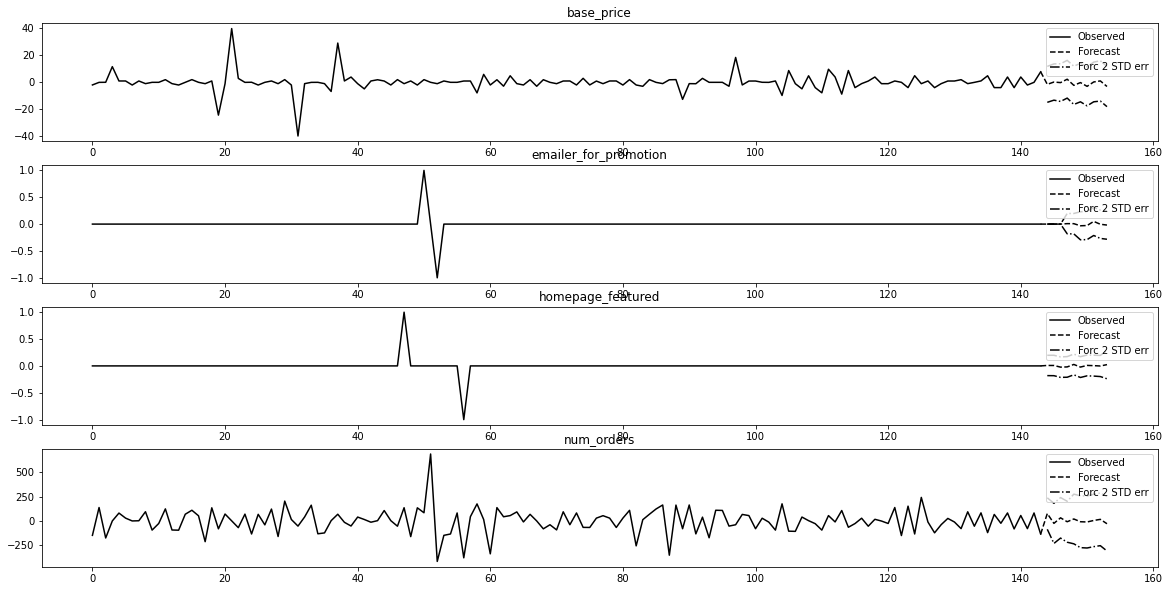

In [34]:
fig = var_results.plot_forecast(10);
fig.set_size_inches(20, 10, forward=True)

In [35]:
#predictions 
var_pred = var_results.forecast(var_results.endog, steps=10)
var_pred

array([[-1.50024874e+00, -2.67037673e-16,  8.32939113e-03,
         7.48837507e+01],
       [ 2.12891606e-01, -9.20984238e-15,  7.76406635e-03,
        -2.58559260e+01],
       [-2.09837133e-01,  1.48001577e-15, -2.28769988e-02,
         3.11669498e+01],
       [ 2.30005152e+00,  8.32939113e-03, -1.88977071e-02,
        -9.23620596e+00],
       [-2.22167930e+00,  7.76406635e-03,  2.72326881e-02,
         1.92679300e+01],
       [-1.85151070e-01, -3.12063899e-02, -2.19000530e-02,
        -9.18584733e+00],
       [-2.97600349e+00, -2.66617734e-02,  9.16893297e-03,
        -1.15492686e+01],
       [ 2.64602490e-01,  5.01096869e-02,  4.72969182e-03,
         3.85322114e+00],
       [ 1.04647883e+00, -3.00234594e-03, -1.60219373e-03,
         1.53350649e+01],
       [-3.08694375e+00, -1.80637551e-02,  2.37723227e-02,
        -2.96625350e+01]])

In [36]:
#converting predictions to dataframe
var_pred_df = pd.DataFrame(index=test_data.index,columns=test_data.columns, data = var_pred.round(2))
var_pred_df['emailer_for_promotion']=var_pred_df['emailer_for_promotion'].clip(lower=0).round(0)
var_pred_df['homepage_featured']=var_pred_df['homepage_featured'].clip(lower=0).round(0)
var_pred_df['num_orders']=var_pred_df['num_orders'].round(0)
# var_pred_df.column
var_pred_df

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
136,-1.50,-0.0,0.0,75.0
137,0.21,-0.0,0.0,-26.0
138,-0.21,0.0,0.0,31.0
139,2.30,0.0,0.0,-9.0
140,-2.22,0.0,0.0,19.0
141,-0.19,0.0,0.0,-9.0
142,-2.98,0.0,0.0,-12.0
143,0.26,0.0,0.0,4.0
144,1.05,-0.0,-0.0,15.0


#### Performing inverse differencing to get actual predictions from differenced predictions

In [37]:
pred = test_data + var_pred_df.shift(1).fillna(0)
pred

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
136,151.38,0.0,0.0,216.0
137,154.73,0.0,0.0,170.0
138,152.53,0.0,0.0,135.0
139,148.20,0.0,0.0,167.0
140,154.65,0.0,0.0,208.0
141,146.19,0.0,0.0,153.0
142,152.16,0.0,0.0,180.0
143,147.37,0.0,0.0,97.0
144,150.61,0.0,0.0,194.0


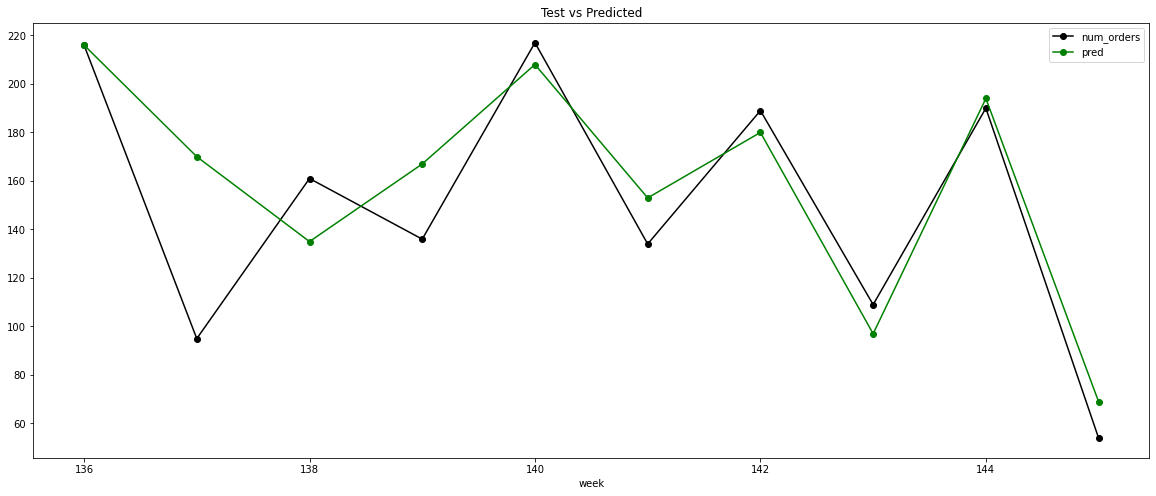

In [38]:
#plot the test vs predictions

#After creating model we will visualize the plot
ax = test_data['num_orders'].plot(marker='o', color='black', figsize=(20,8), legend=True)
pred['num_orders'].plot(marker='o',ax=ax,  color='green', legend=True, label = 'pred')

plt.title('Test vs Predicted')
plt.show()

### Predict future values with VAR

In [39]:
diff_df=demand_df_2.diff().dropna() #to make data stationary, adf test performed earlier

In [40]:
#selecting only required independant variables and output
train_df=diff_df.drop(['checkout_price'], axis = 1)
train_df

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
2,-1.94,0.0,0.0,-149.0
3,-0.03,0.0,0.0,137.0
4,0.03,0.0,0.0,-176.0
5,11.61,0.0,0.0,-1.0
6,1.00,0.0,0.0,80.0
...,...,...,...,...
141,-3.94,0.0,0.0,-83.0
142,3.94,0.0,0.0,55.0
143,-2.00,0.0,0.0,-80.0


In [41]:
#selecting only Ozone and SO2
# test_df=demand_test_df.diff().dropna()
test_df=demand_test_df.drop(['checkout_price'], axis = 1)
test_df['num_orders']=np.nan
test_df

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
146,159.11,0,0,NaN
147,156.20,0,0,NaN
148,159.14,0,0,NaN
149,159.11,0,0,NaN
150,160.11,0,0,NaN
151,159.14,0,0,NaN
152,156.17,0,0,NaN
153,160.11,0,0,NaN
154,158.14,0,0,NaN


In [42]:
var = VAR(train_df)
x= var.select_order()
x.summary()
# train_df

An unsupported index was provided and will be ignored when e.g. forecasting.


,AIC,BIC,FPE,HQIC
0,5.173,5.261,176.5,5.209
1,4.844,5.283,127.0,5.022
2,4.786,5.576,119.9,5.107
3,4.188,5.329,66.06,4.652
4,3.624,5.117,37.72,4.231
5,3.538,5.381,34.77,4.287
6,3.508,5.703,34.04,4.400
7,2.668,5.214,14.85,3.703
8,-50.84,-47.94,8.709e-23,-49.66
9,-52.62,-49.37,1.503e-23,-51.30


In [43]:
var_results = var.fit(10)
#We can check the summary of the model by.
var_results.summary()

invalid value encountered in sqrt


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 13, Dec, 2022
Time:                     20:16:12
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -50.8339
Nobs:                     134.000    HQIC:                  -52.9393
Log likelihood:           3046.95    FPE:                2.61817e-24
AIC:                     -54.3805    Det(Omega_mle):     9.00048e-25
--------------------------------------------------------------------
Results for equation base_price
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.169542         0.588184            0.288           0.773
L1.base_price                    -0.106715         0.096623           -1.104           0.269
L1.emai

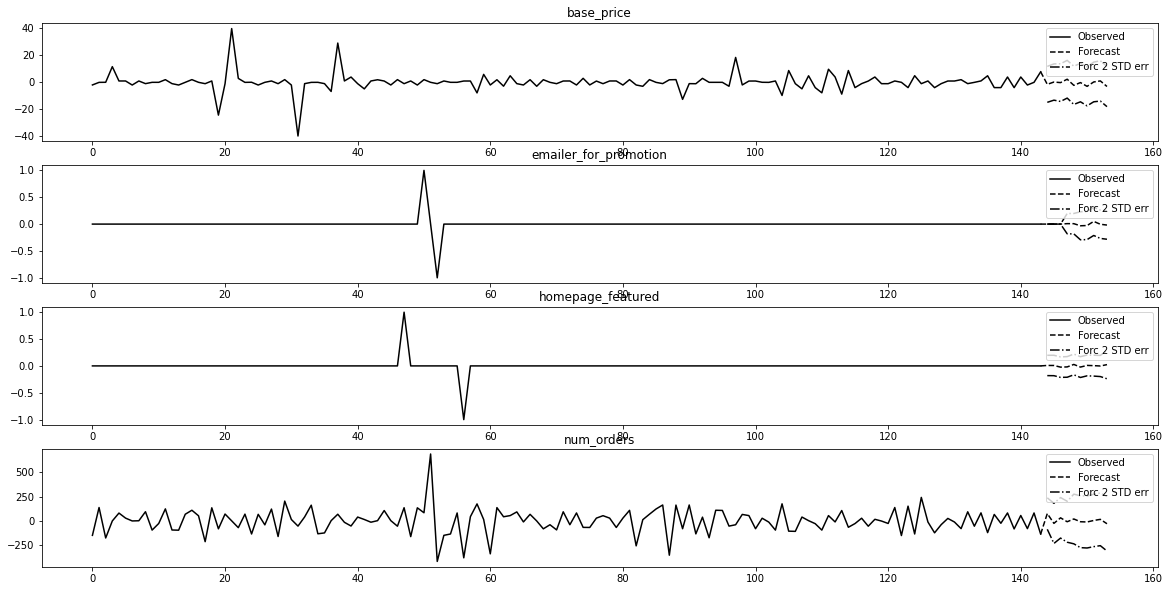

In [44]:
fig = var_results.plot_forecast(10);
fig.set_size_inches(20, 10, forward=True)

In [45]:
#predictions 
var_pred = var_results.forecast(var_results.endog, steps=10)
var_pred

array([[-1.50024874e+00, -2.67037673e-16,  8.32939113e-03,
         7.48837507e+01],
       [ 2.12891606e-01, -9.20984238e-15,  7.76406635e-03,
        -2.58559260e+01],
       [-2.09837133e-01,  1.48001577e-15, -2.28769988e-02,
         3.11669498e+01],
       [ 2.30005152e+00,  8.32939113e-03, -1.88977071e-02,
        -9.23620596e+00],
       [-2.22167930e+00,  7.76406635e-03,  2.72326881e-02,
         1.92679300e+01],
       [-1.85151070e-01, -3.12063899e-02, -2.19000530e-02,
        -9.18584733e+00],
       [-2.97600349e+00, -2.66617734e-02,  9.16893297e-03,
        -1.15492686e+01],
       [ 2.64602490e-01,  5.01096869e-02,  4.72969182e-03,
         3.85322114e+00],
       [ 1.04647883e+00, -3.00234594e-03, -1.60219373e-03,
         1.53350649e+01],
       [-3.08694375e+00, -1.80637551e-02,  2.37723227e-02,
        -2.96625350e+01]])

In [46]:
#converting predictions to dataframe
var_pred_df_fut = pd.DataFrame(index=test_df.index,columns=test_df.columns, data = var_pred.round(2))
var_pred_df_fut['emailer_for_promotion']=var_pred_df_fut['emailer_for_promotion'].clip(lower=0).round(0)
var_pred_df_fut['homepage_featured']=var_pred_df_fut['homepage_featured'].clip(lower=0).round(0)
var_pred_df_fut['num_orders']=var_pred_df_fut['num_orders'].round(0)
var_pred_df_fut

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
146,-1.50,-0.0,0.0,75.0
147,0.21,-0.0,0.0,-26.0
148,-0.21,0.0,0.0,31.0
149,2.30,0.0,0.0,-9.0
150,-2.22,0.0,0.0,19.0
151,-0.19,0.0,0.0,-9.0
152,-2.98,0.0,0.0,-12.0
153,0.26,0.0,0.0,4.0
154,1.05,-0.0,-0.0,15.0


In [47]:
df=demand_df_2.iloc[-10:,-1]
test_df['num_orders']=df.values
test_df


,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
146,159.11,0,0,216
147,156.20,0,0,95
148,159.14,0,0,161
149,159.11,0,0,136
150,160.11,0,0,217
151,159.14,0,0,134
152,156.17,0,0,189
153,160.11,0,0,109
154,158.14,0,0,190


In [48]:
pred_fut = test_df + var_pred_df_fut.shift(1).fillna(0)
pred_fut

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
146,159.11,0.0,0.0,216.0
147,154.70,0.0,0.0,170.0
148,159.35,0.0,0.0,135.0
149,158.90,0.0,0.0,167.0
150,162.41,0.0,0.0,208.0
151,156.92,0.0,0.0,153.0
152,155.98,0.0,0.0,180.0
153,157.13,0.0,0.0,97.0
154,158.40,0.0,0.0,194.0


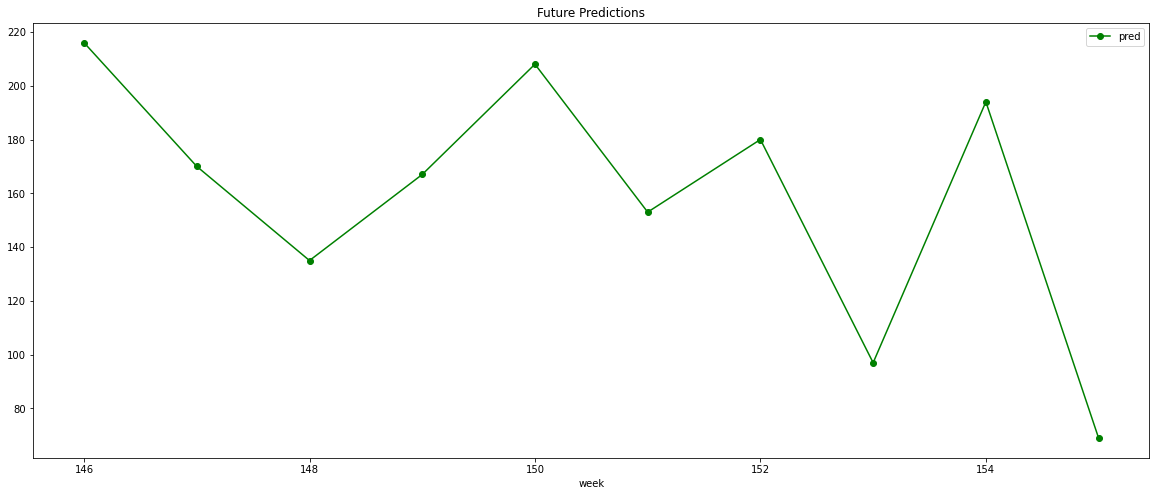

In [49]:
#plot the future predictions

pred_fut['num_orders'].plot(marker='o',  color='green',figsize=(20,8), legend=True, label = 'pred')

plt.title('Future Predictions')
plt.show()

## Forecasting using SARIMAX

In [50]:
#selecting only required independant variables and output, doesnt require stationary data
train_df=demand_df_2.drop(['checkout_price'], axis = 1)
train_df

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
1,135.83,0,0,270
2,133.89,0,0,121
3,133.86,0,0,258
4,133.89,0,0,82
5,145.50,0,0,81
...,...,...,...,...
141,148.41,0,0,134
142,152.35,0,0,189
143,150.35,0,0,109


In [51]:
#selecting only Ozone and SO2
test_df=demand_test_df.drop(['checkout_price'], axis = 1)
test_df['num_orders']=np.nan
test_df

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
146,159.11,0,0,NaN
147,156.20,0,0,NaN
148,159.14,0,0,NaN
149,159.11,0,0,NaN
150,160.11,0,0,NaN
151,159.14,0,0,NaN
152,156.17,0,0,NaN
153,160.11,0,0,NaN
154,158.14,0,0,NaN


In [52]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train_df, test_size=10, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 135
No. of testing examples: 10


In [53]:
train_data

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
1,135.83,0,0,270
2,133.89,0,0,121
3,133.86,0,0,258
4,133.89,0,0,82
5,145.50,0,0,81
...,...,...,...,...
131,148.41,0,0,188
132,149.38,0,0,176
133,151.35,0,0,96


In [54]:
test_data

,base_price,emailer_for_promotion,homepage_featured,num_orders
week,,,,
136,151.38,0,0,216
137,156.23,0,0,95
138,152.32,0,0,161
139,148.41,0,0,136
140,152.35,0,0,217
141,148.41,0,0,134
142,152.35,0,0,189
143,150.35,0,0,109
144,150.35,0,0,190


In [55]:
# SARIMAX Model
sxmodel = pm.auto_arima(train_data[['num_orders']], exogenous=train_data[['base_price', 'emailer_for_promotion','homepage_featured']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=2,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[2]             : AIC=1642.609, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[2]             : AIC=1753.553, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[2]             : AIC=1683.299, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[2]             : AIC=inf, Time=0.06 sec
 ARIMA(1,1,1)(1,1,1)[2]             : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(0,1,2)[2]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,1)(1,1,0)[2]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,1)(1,1,2)[2]             : AIC=inf, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[2]             : AIC=inf, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[2]             : AIC=inf, Time=0.03 sec
 ARIMA(1,1,1)(0,1,1)[2] intercept   : AIC=inf, Time=0.11 sec

Best model:  ARIMA(1,1,1)(0,1,1)[2]          
Total fit time: 1.527 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 2)   Log Likelihood                -817.305
Date:                           Tue, 13 Dec 2022   AIC                           1642.609
Time:                                   20:16:21   BIC                           1654.141
Sample:                                        0   HQIC                          1647.295
                                           - 135                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4589      0.094      4.860      0.000       0.274       0.644
ma.L1         -0.9662      0.047    -20.676      0.000      -1.058      -0.875
ma.S.L2       -0.8613      0.072    -11.946      0.000      -1.003      -0.720
sigma2      1.324e+04    936.474     14.135      0.000    1.14e+04    1.51e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):               799.33
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             1.71
Prob(H) (two-sided):                  0.83   Kurtosis:                        14.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
sarimax_pred = sxmodel.predict(n_periods=10, exogenous=test_data[['base_price', 'emailer_for_promotion','homepage_featured']])
#converting predictions to dataframe
sarimax_pred = pd.DataFrame(index=test_data.index,columns=['num_orders'], data = sarimax_pred.round(0))
# sarimax_pred
sarimax_pred['num_orders']=sarimax_pred['num_orders'].fillna(sarimax_pred['num_orders'].mean())
sarimax_pred

No supported index is available. Prediction results will be given with an integer index beginning at `start`.


,num_orders
week,
136,153.000000
137,144.000000
138,154.000000
139,142.000000
140,151.000000
141,139.000000
142,148.000000
143,135.000000
144,144.000000


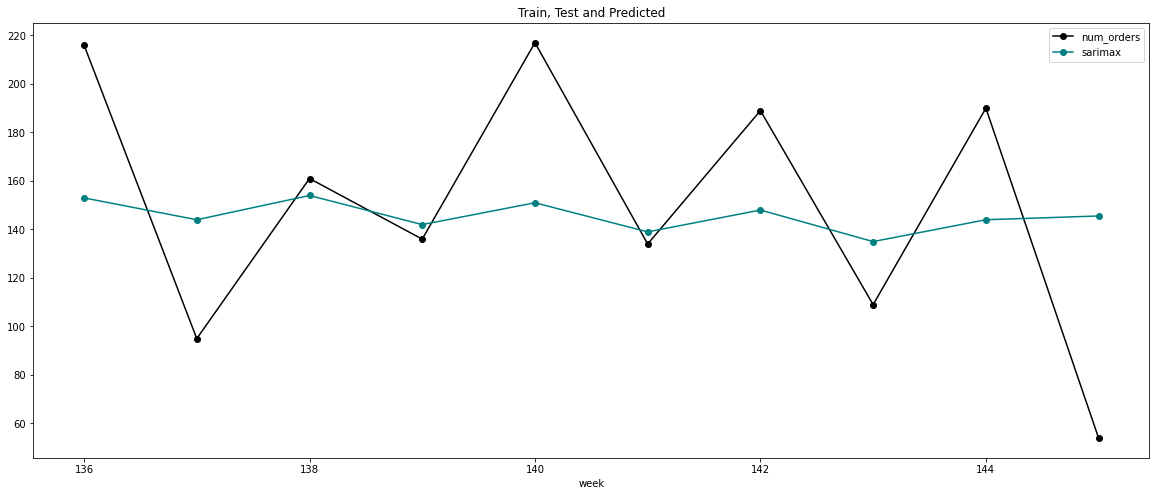

In [57]:
#plot the train, test, and predictions

#After creating model we will visualize the plot
#ax = train_data['O3 AQI'].plot(marker='o', color='black', figsize=(20,8), legend=True)
ax = test_data['num_orders'].plot(marker='o', color='black', figsize=(20,8), legend=True)

#train_data['O3 AQI'].plot(figsize=(20,8), legend=True)
#Plot for double ETS additive
#triple_ets_add_pred.plot(marker='o', ax=ax, color='blue', legend=True, label = 'triple ets add')

#Plot for double ETS multiplicative
#triple_ets_mul_pred.plot(marker='o', ax=ax, color='red', legend=True, label = 'triple ets mul')

# sarima_pred.plot(marker='o', ax=ax, color='orange', legend=True, label = 'sarima')

#var_pred['O3 AQI'].plot(marker='o', ax=ax, color='green', legend=True, label = 'Vector AutoRegression')

sarimax_pred['num_orders'].plot(marker='o', ax=ax, color='teal', legend=True, label = 'sarimax')

plt.title('Train, Test and Predicted')
plt.show()

In [58]:
# SARIMAX Model
sxmodel = pm.auto_arima(train_df[['num_orders']], exogenous=train_df[['base_price', 'emailer_for_promotion','homepage_featured']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=52,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=inf, Time=6.06 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1223.108, Time=0.21 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=2.36 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=3.17 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=1.52 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=4.57 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1214.557, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=3.64 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=7.64 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=1211.662, Time=0.40 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=inf, Time=3.28 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=6.08 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=8.86 sec
 ARIMA(3,1,0)(0,1,0)[52]             : AIC=1210.195, Time=0.51 sec
 ARIMA(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  145
Model:             SARIMAX(3, 1, 0)x(0, 1, 0, 52)   Log Likelihood                -601.097
Date:                            Tue, 13 Dec 2022   AIC                           1210.195
Time:                                    20:17:46   BIC                           1220.282
Sample:                                         0   HQIC                          1214.266
                                            - 145                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4624      0.124     -3.744      0.000      -0.704      -0.220
ar.L2         -0.3230      0.145     -2.232      0.026      -0.607      -0.039
ar.L3         -0.1972      0.136     -1.454      0.146      -0.463       0.069
sigma2       2.77e+04   2171.985     12.755      0.000    2.34e+04     3.2e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               161.68
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -1.37
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
sarimax_pred_fut = sxmodel.predict(n_periods=10, exogenous=test_df[['base_price', 'emailer_for_promotion','homepage_featured']])
#converting predictions to dataframe
sarimax_pred_fut = pd.DataFrame(index=test_df.index,columns=['num_orders'], data = sarimax_pred_fut.round(2))
sarimax_pred_fut

,num_orders
week,
146,119.21
147,-50.55
148,48.09
149,153.15
150,102.56
151,63.65
152,128.43
153,181.97
154,101.36


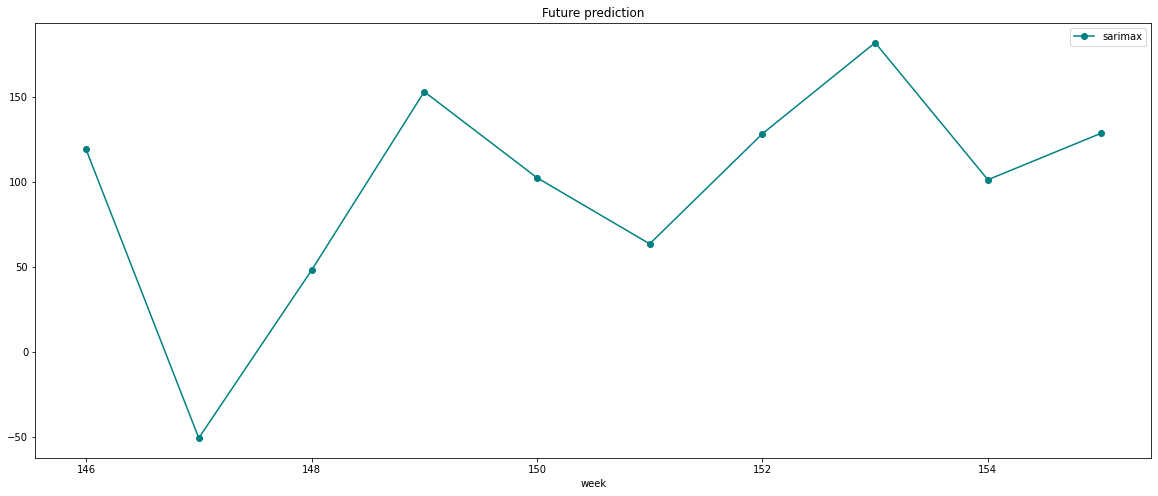

In [60]:
#plot the future predictions

sarimax_pred_fut['num_orders'].plot(marker='o',  color='teal', figsize=(20,8), legend=True, label = 'sarimax')

plt.title('Future prediction')
plt.show()

In [65]:
prediction_df= test_data
prediction_df['Var_pred']=pred['num_orders']
prediction_df['Sarimax_pred']=sarimax_pred['num_orders']
prediction_df['Average_pred']= (pred['num_orders']+sarimax_pred['num_orders'])/2
# test_pred_df
prediction_df

,base_price,emailer_for_promotion,homepage_featured,num_orders,Var_pred,Sarimax_pred,Average_pred
week,,,,,,,
136,151.38,0,0,216,216.0,153.000000,184.500000
137,156.23,0,0,95,170.0,144.000000,157.000000
138,152.32,0,0,161,135.0,154.000000,144.500000
139,148.41,0,0,136,167.0,142.000000,154.500000
140,152.35,0,0,217,208.0,151.000000,179.500000
141,148.41,0,0,134,153.0,139.000000,146.000000
142,152.35,0,0,189,180.0,148.000000,164.000000
143,150.35,0,0,109,97.0,135.000000,116.000000
144,150.35,0,0,190,194.0,144.000000,169.000000


### Accuracy metrics

In [69]:
#define metrics dataframe which will be used below for 
metrics_dataframe = pd.DataFrame(columns=['Model', 'R2', 'RMSE', 'MAE', 'MAPE'])

                                 
def metrics_cal(actuals, predictions, model):
    print()
    r2 = metrics.r2_score(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    df = pd.DataFrame({'Model': model,
                       'R2': r2,
                       'RMSE': rmse,
                       'MAE': mae, 
                       'MAPE': mape}, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [70]:
#get all the metrics


metrics_dataframe = metrics_cal(test_data['num_orders'].values.flatten(), 
                                prediction_df['Sarimax_pred'].values.flatten(), 
                                'SARIMAX')

metrics_dataframe = metrics_cal(test_data['num_orders'].values.flatten(), 
                                prediction_df['Var_pred'].values.flatten(), 
                                'VAR')
metrics_dataframe = metrics_cal(test_data['num_orders'].values.flatten(), 
                                prediction_df['Average_pred'].values.flatten(), 
                                'Average prediction')



The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [71]:
metrics_dataframe.sort_values(by="MAE", ascending=True)

,Model,R2,RMSE,MAE,MAPE
0,VAR,0.691243,28.583212,20.0,18.187124
0,Average prediction,0.586011,33.097616,28.427778,25.929892
0,SARIMAX,0.104663,48.673833,40.055556,36.295548


# VAR has the least overall error hence it is the model currently to predict the future. Since there can be severeal other factors impacting the demand of the food, the model isn't able to predict very accurately. For future improvements, AI models can be implemented for better forecasting and decision making. Also training the model with more features to increase the model complexity so that our model learns better and give improved forecasting.